### Load data
There are 6 folders: train, val, test, and mask for each of them
You should run mask_creator before running this notebook, or create these folders manually.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import time
import copy
import random

DATA_DIR = 'E:\\few_data\\th\\'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

def visualize(**images):
    n = len(images)
    for i, (name, image) in enumerate(images.items()):

        plt.figure(figsize=(25, 25))
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [2]:
class DatasetImg(BaseDataset):
    CLASSES = ['coal','bound']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:-3]+"png") for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])[:, :, 1:3] / 255.0

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids) #len filenames

### Visualize data

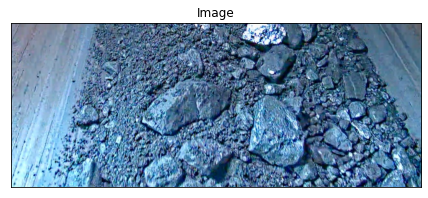

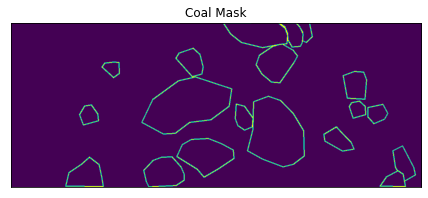

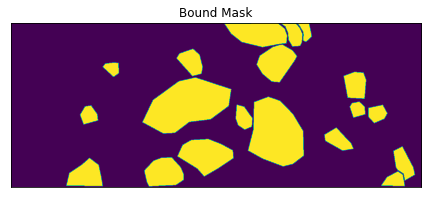

In [3]:
dataset = DatasetImg(x_train_dir, y_train_dir, classes=['coal','bound'])

image, mask = dataset[0]
visualize(
    image=image,
    coal_mask=mask[..., 0].squeeze(),
    bound_mask=mask[..., 1].squeeze(),
)

### Augmentations

In [4]:
def get_training_augmentation():
    return albu.Compose([
        albu.RandomCrop(height=512, width=512,p=1.0),
        albu.OneOf(
            [
            albu.HorizontalFlip(p=1.0),
            albu.VerticalFlip(p=1.0),
            albu.RandomRotate90(p=1.0),
            #albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

            ],p=0.8),
        #albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.2),
        albu.OneOf(
            [
                albu.RandomBrightness(p=1),
                albu.CLAHE(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.7,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.RandomBrightnessContrast(p=1.0),
            ],
            p=0.7,
        ),
        #CopyPaste(blend=True, sigma=1, pct_objects_paste=0.5, p=1),
    ])

def get_validation_augmentation():
    return albu.Compose([
        albu.OneOf(
        [
            albu.HorizontalFlip(p=1.0),
            albu.VerticalFlip(p=1.0),
            albu.RandomBrightness(p=0.5),
        ],p=0.7),

        albu.RandomCrop(height=512, width=512, p=1.0),
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Visualize augmentations

c:\users\sergey\pycharmprojects\test\venv\lib\site-packages\albumentations\augmentations\transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
c:\users\sergey\pycharmprojects\test\venv\lib\site-packages\albumentations\augmentations\transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


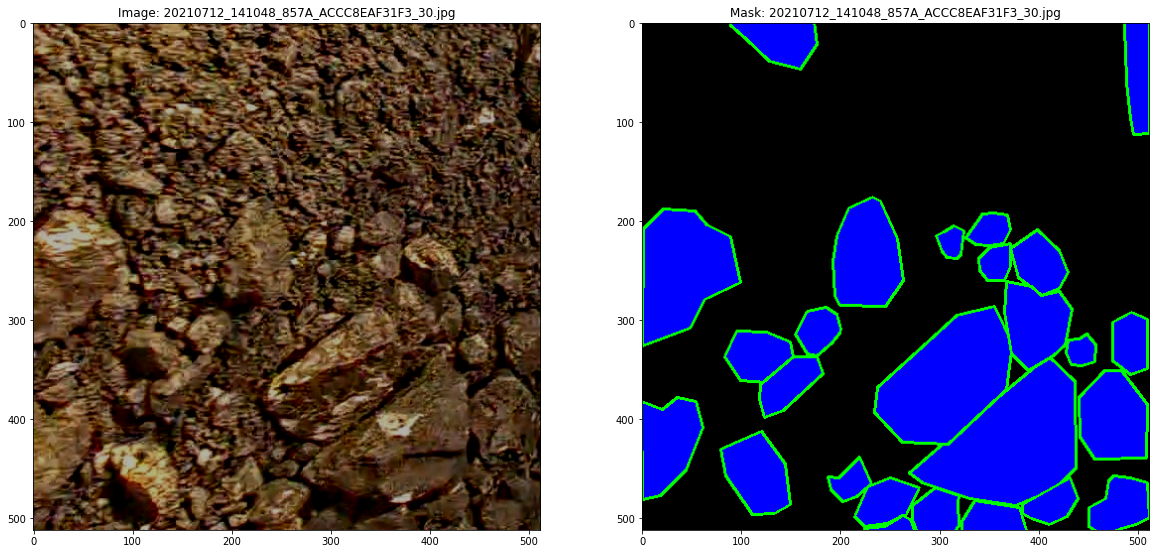

In [5]:
def show_examples(name, image, mask):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")

def show(image_path, masks, transforms=None):
    image = cv2.imread(image_path)
    mask = cv2.imread(masks)

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(image_path.split('\\')[-1], image, mask)

show(DATA_DIR + "train\\20210712_141048_857A_ACCC8EAF31F3_30.jpg",
     DATA_DIR + "trainannot\\20210712_141048_857A_ACCC8EAF31F3_30.png",
     transforms=get_training_augmentation())



### Initialize model

In [6]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['coal','bound']
ACTIVATION = 'sigmoid'
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'


aux_params=dict(
    dropout=0.2,
    classes=2,
)

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    # aux_params=aux_params,
    activation=ACTIVATION,
)
#preprocessing_fn = lambda x: x /255.0
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print(preprocessing_fn)



functools.partial(<function preprocess_input at 0x000002155144BB70>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


### Initialize dataset

In [7]:
train_dataset = DatasetImg(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = DatasetImg(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataset = DatasetImg(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True)


In [8]:
from torch import nn

class OwnLoss(nn.Module):
    __name__ = "own"

    def __init__(self):
        super(OwnLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss('binary', from_logits=False)
        self.bce_loss = torch.nn.BCELoss()

    def forward(self, out, target):
        # out = np.asarray(out)[0].round()
        # out = out.type(torch.LongTensor)
        # target = target.type(torch.LongTensor)
        # out = out.to(DEVICE)
        # target = target.to(DEVICE)
        # print(out.shape)
        loss1 = self.dice_loss(out, target)
        loss2 = self.bce_loss(out, target)
        loss_extra = self.bce_loss(out[:,1:2] * target[:,0:1].to(DEVICE),
                                   torch.zeros_like(target[:,0:1], dtype=torch.float32, device=DEVICE))
        loss_sum = loss1 + 2 * loss2 + 5 * loss_extra
        return loss_sum

In [9]:
loss = OwnLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.8),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=3e-4),
])

In [10]:

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=torch.device(DEVICE),
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=torch.device(DEVICE),
    verbose=True,
)


### Train model

In [ ]:
max_score = 0
val_scores = []
train_scores = []

val_own_loss = []
train_own_loss = []
j = 0
for i in range(0, 55):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    val_scores.append(valid_logs['iou_score'])
    train_scores.append(train_logs['iou_score'])

    val_own_loss.append(valid_logs['own'])
    train_own_loss.append(train_logs['own'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model3.pth')
        j = i
print("Used model from", j, "epoch")

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_own_loss, label="val")
plt.plot(train_own_loss, label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("IoU Score")
plt.plot(val_scores, label="val")
plt.plot(train_scores, label="train")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.legend()
plt.show()


### Evaluate model

In [12]:
best_model = torch.load('./best_model3.pth')
best_model.eval()

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)
#logs = test_epoch.run(test_dataloader)


### Visualize result
#### Setup params

In [13]:
if not os.path.exists(DATA_DIR + 'result/'):
    os.makedirs(DATA_DIR + 'result/')
path = DATA_DIR + "result/"

image_name = 'vlcsnap-2022-01-26-cut.jpg'
image_path = DATA_DIR + 'test/' + image_name
threshold = 0.5

best_model = torch.load('./best_model3.pth')
best_model.eval();

### Test with specific threshold

Elapsed time, s: 0.03813004493713379
(512, 1120, 1)


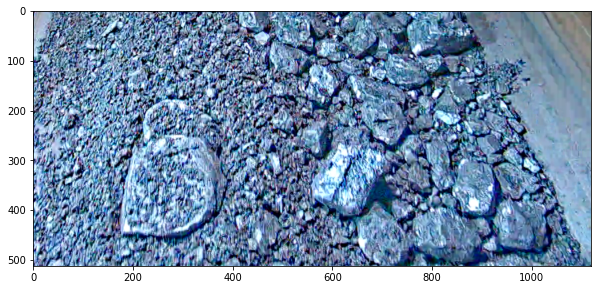

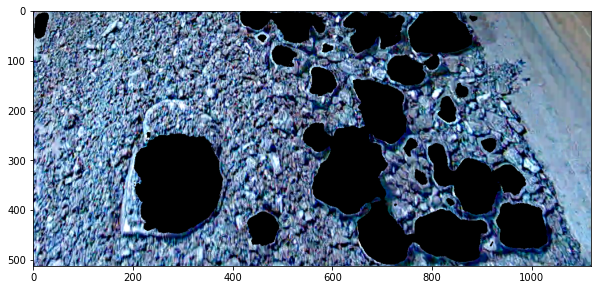

In [14]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy().astype('float32')
orig_int = image.copy()

trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])
image = trf(image=image)['image']
image = image.transpose(2, 0, 1).astype('float32')

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
start = time.time()
pr_mask = best_model.predict(x_tensor).squeeze(0).cpu().numpy()
end = time.time()
print("Elapsed time, s:",end - start)
pr_mask = pr_mask.transpose(1,2,0)
pr_mask_norm = np.where(pr_mask[:,:,1:2] > threshold, 0, 255)
pr_mask_norm_edge = np.where(pr_mask[:,:,0:1] > 0.1, 0, 255)
print(pr_mask_norm.shape)
mask, edges = pr_mask_norm, pr_mask_norm_edge
test = pr_mask[:,:,1:2]
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)

res_thr = cv2.bitwise_and(orig_int, orig_int, mask=mask.astype(dtype=np.uint8))
cv2.imwrite(path + "mask_" + str(threshold) + image_name, mask.astype(dtype=np.uint8))
cv2.imwrite(path + "edge_" + str(threshold) + image_name, edges.astype(dtype=np.uint8))
cv2.imwrite(path + "result_prob_" + str(threshold) + image_name, cv2.multiply(orig, test))
cv2.imwrite(path + "result_thr_" + str(threshold) + image_name, res_thr)
cv2.imwrite(path + "orig_thr_" + str(threshold) + image_name, orig_int)

plt.figure(figsize=(10, 10))
plt.imshow(orig_int)
plt.figure(figsize=(10, 10))
plt.imshow(res_thr)

### Trying to find best threshold based on postprocessing

In [15]:
# https://gist.github.com/bowenc0221/71f7a02afee92646ca05efeeb14d687d
# Test IoU
import cv2
import numpy as np


# General util function to get the boundary of a binary mask.
def mask_to_boundary(mask):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h,w = mask.shape[0], mask.shape[1]
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(0.2 * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv2.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode


def boundary_iou(gt, dt):
    """
    Compute boundary iou between two binary masks.
    :param gt (numpy array, uint8): binary mask
    :param dt (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary iou (float)
    """
    gt_boundary = mask_to_boundary(gt )
    dt_boundary = mask_to_boundary(dt)
    intersection = ((gt_boundary * dt_boundary) > 0).sum()
    union = ((gt_boundary + dt_boundary) > 0).sum()
    boundary_iou = intersection / union
    return boundary_iou

### Dilate to eliminate a border effects

0.26404169079328316


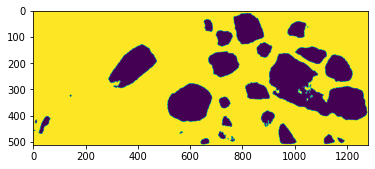

In [16]:
### Test
from matplotlib import pyplot as plt
gt = cv2.imread(r"E:\few_data\th\mask_cut\20210712_141048_857A_ACCC8EAF31F3_0.jpg")
dt = cv2.imread(r"E:\few_data\th\resultunet\mask_0.520210712_141048_857A_ACCC8EAF31F3_0.jpg")

dt = cv2.dilate(dt,(4,4),dt,iterations=5)
gt = cv2.resize(gt,(1280,512))

gt = cv2.cvtColor(gt,cv2.COLOR_BGR2GRAY)
dt = cv2.cvtColor(dt,cv2.COLOR_BGR2GRAY)

print(boundary_iou(gt=gt,dt=dt))
#cv2.imwrite(r"E:\few_data\th\result\test.png",dt)
plt.imshow(dt)

### Nested contours

In [17]:
contours, hierarchy  = cv2.findContours(dt, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
res_img = cv2.imread(r"E:\few_data\th\mask_cut_2_class\20210712_141048_857A_ACCC8EAF31F3_0.png")
print(len(contours[0]))
img = cv2.drawContours(res_img, contours,-1, (155,75,75), 2)
cv2.imwrite(r"E:\few_data\th\resultunet\test.png",img)

3580


True